In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import random

In [3]:
size = 30
Maze = [[1 for _ in range(size)] for _ in range(size)]
# random.seed(42)

### Maze generation 
THANKS TO [LINK](https://www.youtube.com/watch?v=Y37-gB83HKE)

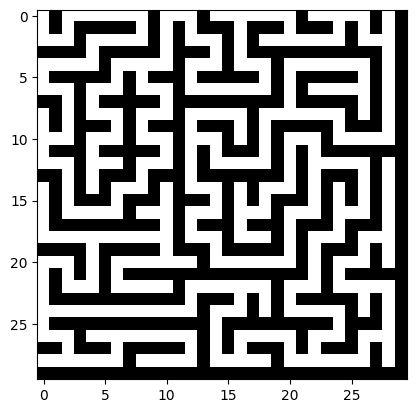

In [4]:
def DFS_maze_generation(Maze, x, y, size):
    if (x==size-1 and y==size-1):
        Maze[x][y] = 0
        return 
    directions = [(0, 2), (2, 0), (0, -2), (-2, 0)]
    random.shuffle(directions)

    for l1, l2 in directions:
        X, Y = x + l1, y + l2
        if ((0 <= X < size and 0 <= Y < size) and Maze[X][Y] == 1):
            Maze[x + l1 // 2][y + l2 // 2] = 0
            Maze[X][Y] = 0
            DFS_maze_generation(Maze, X, Y, size)

def create_maze_with_obstacles(Maze, size):
    start = (0, 0)
    Maze[start[0]][start[1]] = 0 
    DFS_maze_generation(Maze, start[0], start[1], size)
    return Maze
maze = create_maze_with_obstacles(Maze, size)
plt.imshow(np.ones(1) - maze,cmap='gray')
plt.show()

### MDP using DP

In [5]:
class MDP():
    def __init__(self, Maze):
        self.V = np.zeros(np.array(Maze).shape)  ### Expected returns  st current state s
        self.gamma = 0.7
        self.Maze = Maze
        self.Action = ['up', 'down', 'left', 'right']
        self.direction = [(1, 0), (-1, 0), (0, -1), (0, 1)]
        self.prob_action = [random.random() for _ in self.Action]
        self.goal = (len(self.Maze[0]) -1 , len(self.Maze)-1)
    
    def score(self, Action, pastscore):
        # this will basically give us the score for a state 
        return (Action + self.gamma * pastscore)
    
    def Environment(self, pos):
        # If possible to move env will grade it with 10 else -10
        if (self.Maze[pos[0]][pos[1]]==1):
            return -10
        else:
            return 10

    def Find(self, pos):
        # Possible actions
        Path  = []
        if(pos[0]==self.goal[0] and pos[1]==self.goal[1]):
            ## Breaking Condition
            self.V[pos[0]-1][pos[1]-1]==100
            return 100

        ## Finding all possible paths
        for i in range(len(self.Action)):
            prob = random.random()
            count = 0
            x = pos[0] + self.direction[i][0]
            y = pos[1] + self.direction[i][1]
            if (prob>=self.prob_action[i] or (x==self.goal[0] and y==self.goal[1]) or count > 0):
                if ( 0 <= x<self.V.shape[0] and  0 <= y < self.V.shape[1] and self.V[x][y] == 0):
                    # If not Find
                    Path.append(self.Find((x,y)))
                elif (0 <= x < self.V.shape[0] and  0<= y < self.V.shape[1] ):
                    # If already available take that score
                    Path.append(self.V[x][y]) 
            else:
                count +=1
                Path.append(0)
        # Futher Scoring and Updating
        Score = [self.score(self.Environment(pos), pathscore) for pathscore in Path]
        self.V[pos[0]][pos[1]] = max(Score)
        return self.V[pos[0]][pos[1]]
    
    def Start(self):
        # Starts the process
        self.Find(pos=(0,0))
        print("Done") 
    def Scores(self):
        # returns the score
        return self.V

Done


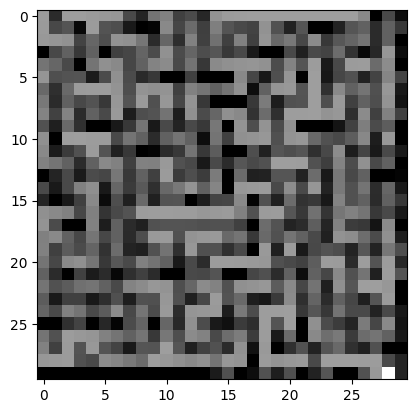

In [55]:
Solver = MDP(Maze)
Solver.Start()
Best = Solver.Scores()
plt.imshow(Best,cmap='gray')
plt.show()

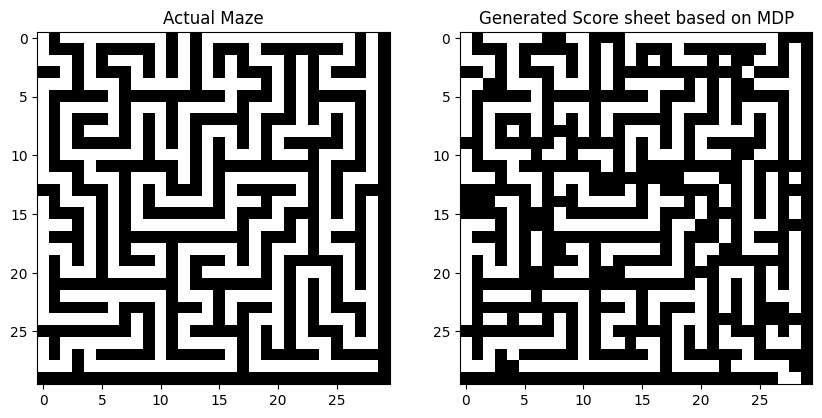

In [66]:
fig, axis = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(10)
axis[0].title.set_text('Actual Maze')
axis[0].imshow(np.array(1) - Maze,cmap='gray')
axis[1].title.set_text('Generated Score sheet based on MDP')
axis[1].imshow((Best>15).astype('int'),cmap='gray')
plt.show()

### Q-Learning

In [17]:
class QLearning:
    def __init__(self, Maze, alpha=0.1, gamma=0.7, epsilon=0.1, episodes=10):
        self.Maze = Maze
        self.QTable = np.zeros((*Maze.shape, 4))
        self.goal = (Maze.shape[0] - 1, Maze.shape[1] - 1)
        self.actions = ['up', 'down', 'left', 'right']
        self.directions = [(-1, 0), (1, 0), (0, -1), (0, 1)] 
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.episodes = episodes

    def Environment(self, pos):
        # Define rewards for different cell types
        if pos == self.goal:
            return 100  
        elif self.Maze[pos[0]][pos[1]] == 1:
            return -10
        else:
            return -1

    def choose_action(self, pos):
        # Epsilon-greedy action selection
        if random.uniform(0, 1) < self.epsilon:
            return random.choice(range(4))
        else:
            return np.argmax(self.QTable[pos[0], pos[1]])

    def update_q_value(self, pos, action, reward, next_pos):
        best_next_action = np.argmax(self.QTable[next_pos[0], next_pos[1]])
        td_target = reward + self.gamma * self.QTable[next_pos[0], next_pos[1], best_next_action]
        td_error = td_target - self.QTable[pos[0], pos[1], action]
        self.QTable[pos[0], pos[1], action] += self.alpha * td_error

    def Training(self):
        for episode in range(self.episodes):
            pos = (0, 0)

            while pos != self.goal:
                action = self.choose_action(pos)
                direction = self.directions[action]
                next_pos = (pos[0] + direction[0], pos[1] + direction[1])

                if 0 <= next_pos[0] < self.Maze.shape[0] and 0 <= next_pos[1] < self.Maze.shape[1]:
                    reward = self.Environment(next_pos)
                    self.update_q_value(pos, action, reward, next_pos)
                    pos = next_pos
                else:
                    self.update_q_value(pos, action, -10, pos)

        print("Training completed. Q-table:")
        return (self.QTable.sum(axis=2))/self.QTable.shape[-1]

Training completed. Q-table:


Training completed. Q-table:


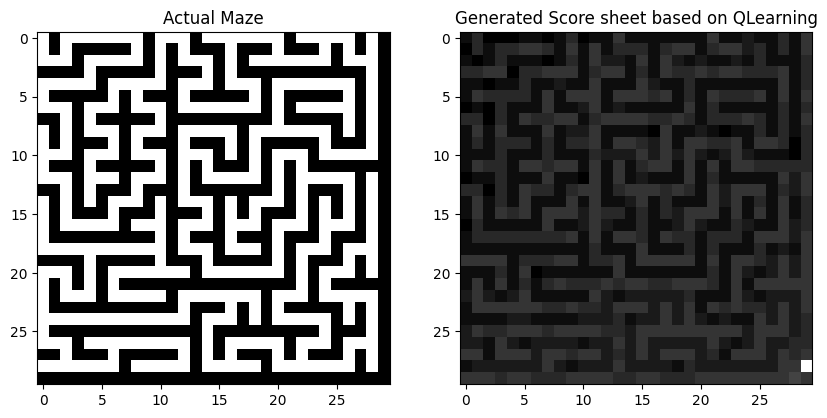

In [25]:
qlearning = QLearning(np.array(Maze))
Qtable = qlearning.Training()
fig, axis = plt.subplots(1,2)
fig.set_figheight(10)
fig.set_figwidth(10)
axis[0].title.set_text('Actual Maze')
axis[0].imshow(np.array(1) - Maze,cmap='gray')
axis[1].title.set_text('Generated Score sheet based on QLearning')
axis[1].imshow((Qtable).astype('int'),cmap='gray')
plt.show()

### DONE